In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, Debye_Sum_Ser_t
from masa_utils_pytorch import Optimization

# multiple reference models Pelton model

In [4]:
# low time constant 
tau_true=0.1
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(tau_true), 0.5], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()

parm_ref1 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref2 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref3 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref4 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)

nref= 4
parm_ref = [parm_ref1, parm_ref2, parm_ref3, parm_ref4]

# Define TDIP using Frecuency model

In [5]:
basefreq = 0.125
duty = 0.5
tstrt = 0
tend = 8.0
ntime = 2**12
print(ntime)
tstep = (tend - tstrt) / ntime
print(tstep)
ftesp = 1 / tend
times = np.arange(tstrt, tend, tstep)
freq = np.fft.fftfreq(ntime, tstep)
# freq =  np.arange(ntime) * ftesp / ntime
print(freq)
print(times)
print(times.shape)
print(freq.shape)

4096
0.001953125
[ 0.     0.125  0.25  ... -0.375 -0.25  -0.125]
[0.00000000e+00 1.95312500e-03 3.90625000e-03 ... 7.99414062e+00
 7.99609375e+00 7.99804688e+00]
(4096,)
(4096,)


In [6]:
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(
    ip_model=IP_model,
    mode="tdip_f",
    times=times,
    log2max=6,
    log2min=-6
    )
# print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)

torch.Size([4096])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])


Source wave form: 0.125 base frequency\
Time range 0-8sec, full waveform\
50Hz sammling data\
Windoes 25Hz, every 0.04sec\


In [ ]:
basefreq = 0.125
curr_duty = 0.5
smp_freq = 50
nlin = 4
nlin_strt = 2
sim.set_current_wave(basefreq=basefreq, curr_duty=curr_duty)
sim.get_windows_matrix_curr(smp_freq=smp_freq, nlin=nlin, nlin_strt=nlin_strt)
print(sim.windows_strt)
print(sim.windows_end)
windows_cen = (sim.windows_strt + sim.windows_end) / 2

tensor([0.0300, 0.0500, 0.0700, 0.0900, 0.1100, 0.1350, 0.1688, 0.2109, 0.2637,
        0.3296, 0.4120, 0.5150, 0.6437, 0.8047, 1.0058, 1.2573, 1.5716, 1.9645,
        2.4556, 3.0695, 4.0300, 4.0500, 4.0700, 4.0900, 4.1100, 4.1350, 4.1687,
        4.2109, 4.2637, 4.3296, 4.4120, 4.5150, 4.6437, 4.8047, 5.0058, 5.2573,
        5.5716, 5.9645, 6.4556, 7.0695])
tensor([0.0500, 0.0700, 0.0900, 0.1100, 0.1350, 0.1688, 0.2109, 0.2637, 0.3296,
        0.4120, 0.5150, 0.6437, 0.8047, 1.0058, 1.2573, 1.5716, 1.9645, 2.4556,
        3.0695, 4.0000, 4.0500, 4.0700, 4.0900, 4.1100, 4.1350, 4.1687, 4.2109,
        4.2637, 4.3296, 4.4120, 4.5150, 4.6437, 4.8047, 5.0058, 5.2573, 5.5716,
        5.9645, 6.4556, 7.0695, 8.0000])


In [9]:
print(sim.times.shape)
print(np.log2(sim.times.shape[0]))
sim.count_data_windows(sim.times)
print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)

torch.Size([4096])
12.0
torch.Size([4096])
torch.Size([4096])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])


In [10]:
nhalf = len(sim.windows_strt)//2
count = sim.count_data_windows(sim.times)
print(count[:nhalf])
print(count[nhalf:])
print(count[nhalf-1], count[-1])

tensor([ 10.,  10.,  11.,  10.,  13.,  17.,  22.,  28.,  34.,  42.,  53.,  66.,
         82., 103., 129., 161., 201., 252., 314., 477.])
tensor([ 10.,  10.,  11.,  10.,  13.,  17.,  22.,  28.,  34.,  42.,  53.,  66.,
         82., 103., 129., 161., 201., 252., 314., 476.])
tensor(477.) tensor(476.)


In [11]:

dobs_clean=sim.dpred(parm_true).detach()
abs_max = max(abs(dobs_clean)).detach().numpy()
relative_error = torch.tensor(0.01)
noise_floor = torch.tensor(abs_max * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )


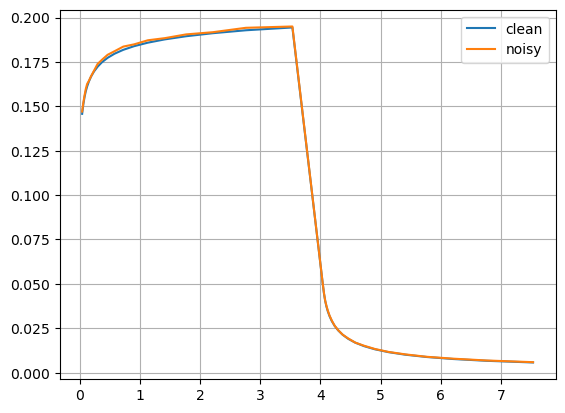

In [12]:
plt.plot(windows_cen, dobs_clean.numpy(), label='clean')
plt.plot(windows_cen, dobs.numpy(), label='noisy')
# plt.plot(windows_cen, dinit.numpy(), label='init')
plt.legend()
plt.grid()

In [13]:

print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)
print(sim.ip_model.freq[0])
print(sim.ip_model.freq[-1])
# freq = sim.ip_model.freq

torch.Size([4096])
torch.Size([4096])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])
tensor(0.+0.j)
tensor(-0.1250+0.j)


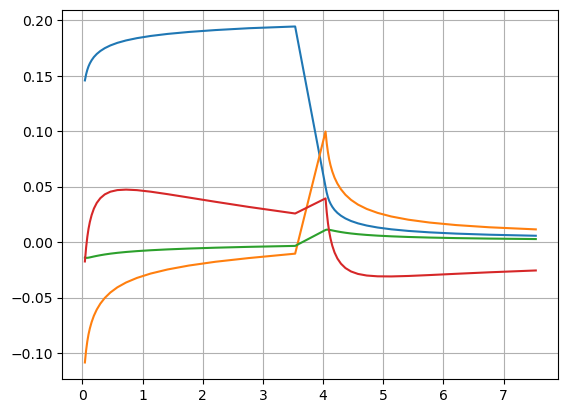

In [14]:

J =sim.J(parm_true)
plt.plot(windows_cen, J.numpy(), label='J')

plt.grid()

# Optimization

In [15]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(len(parm_ref1))

In [16]:
print(opt.Wd)

tensor([[ 674.1083,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,  652.2054,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,  635.6953,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., 4766.5103,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000, 4849.7988,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
         4920.9082]])


In [17]:
beta0_ratio = 1
niter = 80
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu= 1e-3

In [18]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    beta0 = opt.BetaEstimate_byEig(
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.6322e+08)
  1, beta:1.6e+08, step:9.5e-07, gradient:1.5e+05,  f:4.3e+04
  2, beta:1.6e+08, step:9.5e-07, gradient:2.2e+08,  f:1.9e+05
  3, beta:8.2e+07, step:1.9e-06, gradient:1.1e+08,  f:4.3e+04
  4, beta:8.2e+07, step:9.5e-07, gradient:1.1e+08,  f:8.1e+04
  5, beta:4.1e+07, step:1.9e-06, gradient:5.5e+07,  f:4.3e+04
  6, beta:4.1e+07, step:9.5e-07, gradient:5.4e+07,  f:5.2e+04
  7, beta:2.0e+07, step:1.9e-06, gradient:2.7e+07,  f:4.3e+04
  8, beta:2.0e+07, step:9.5e-07, gradient:2.7e+07,  f:4.5e+04
  9, beta:1.0e+07, step:1.9e-06, gradient:1.4e+07,  f:4.3e+04
 10, beta:1.0e+07, step:9.5e-07, gradient:1.3e+07,  f:4.3e+04
 11, beta:5.1e+06, step:1.9e-06, gradient:6.9e+06,  f:4.3e+04
 12, beta:5.1e+06, step:9.5e-07, gradient:6.7e+06,  f:4.3e+04
 13, beta:2.6e+06, step:1.9e-06, gradient:3.5e+06,  f:4.3e+04
 14, beta:2.6e+06, step:9.5e-07, gradient:3.3e+06,  f:4.3e+04
 15, beta:1.3e+06, step:9.5e-07, gradient:1.7e+06,  f:4.3e+04
 16, beta:1.3e+06, step:9.5e-07, gradient:1.8e+06, 

In [19]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 2.20e-01 & 0.100 & 5.00e-02 & 0.600
est1     & 2.01e-01 & 0.605 & 5.33e-02 & 0.467
ref2     & 2.20e-01 & 0.100 & 2.00e-01 & 0.600
est2     & 2.01e-01 & 0.400 & 2.01e-01 & 0.546
ref3     & 2.20e-01 & 0.100 & 5.00e-02 & 0.400
est3     & 2.01e-01 & 0.611 & 5.18e-02 & 0.465
ref4     & 2.20e-01 & 0.100 & 2.00e-01 & 0.400
est4     & 2.01e-01 & 0.405 & 1.95e-01 & 0.543
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [20]:
nwindow = len(windows_cen)
ind_on = windows_cen <= duty*(1/basefreq)
ind_off = windows_cen > duty*(1/basefreq)
windows_on = windows_cen[ind_on]
windows_off = windows_cen[ind_off]
windows_off_0 = windows_off-duty*(1/basefreq)


In [21]:
dest_on_np =[]
dest_off_np =[]
dinit_on_np =[]
dinit_off_np =[]
dest_J_on_np =[]
dest_J_off_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dest_J = sim.J(parm_ref[i]).detach().numpy()
    dest_J_on_np.append(dest_J[ind_on])
    dest_J_off_np.append(dest_J[ind_off])
    dest_on_np.append(dest[ind_on]) 
    dest_off_np.append(dest[ind_off])
    dinit = dinit_refs[i].detach().numpy()
    dinit_on_np.append(dinit[ind_on])
    dinit_off_np.append(dinit[ind_off])
dobs_on = dobs[ind_on].detach().numpy().flatten()
dobs_off = dobs[ind_off].detach().numpy().flatten()


In [22]:
PL_tdip = PsuedoLog(
            logmin=1e-3,
            linScale=0.2,
            logminx=0.1,
            linScalex=0.5)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


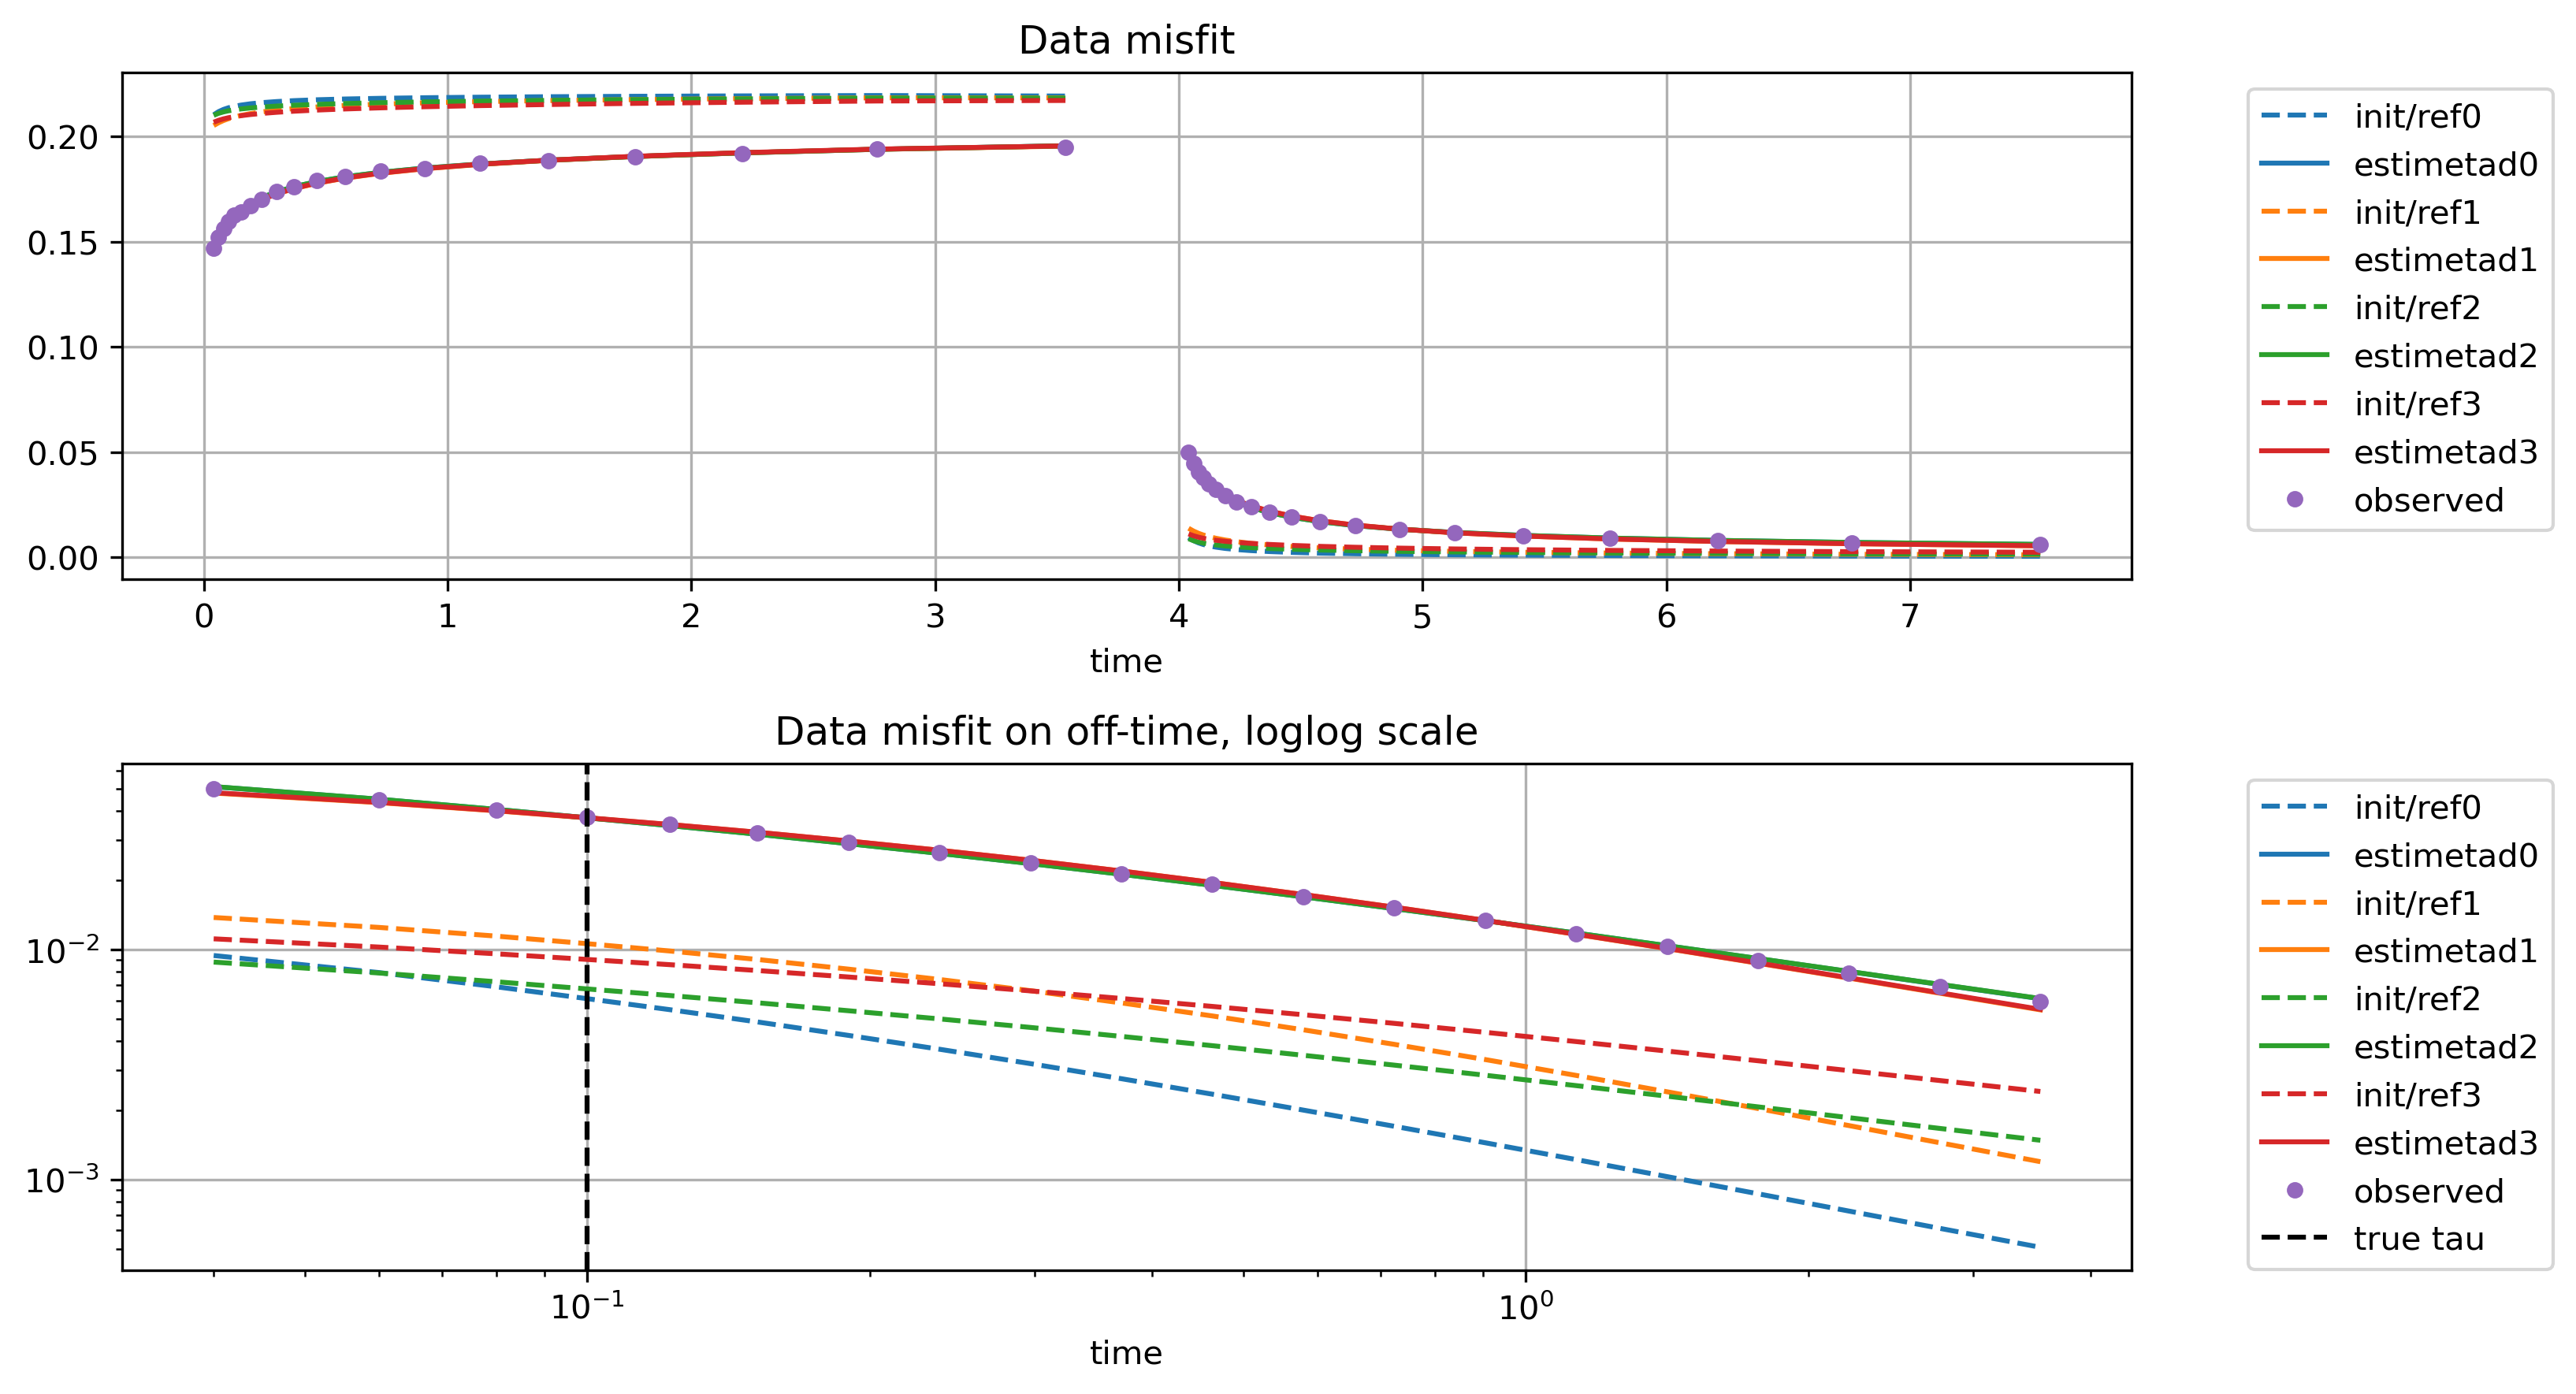

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

for i in range(nref):
    ax[0].plot(windows_on,dinit_on_np[i], f'C{i}', linestyle="--",label=f'init/ref{i}')
    ax[0].plot(windows_off,dinit_off_np[i], f'C{i}', linestyle="--")
    ax[0].plot(windows_on,dest_on_np[i], f'C{i}', label=f'estimetad{i}')
    ax[0].plot(windows_off,dest_off_np[i], f'C{i}')

ax[0].plot(windows_on,dobs_on, f'C{nref}', label='observed',
           linestyle="",markersize=4.0, marker="o",)
ax[0].plot(windows_off,dobs_off, f'C{nref}',
           linestyle="",markersize=4.0, marker="o")

for i in range(nref):
      ax[1].loglog(windows_off_0, dinit_off_np[i], color=f'C{i}', linestyle="--",label=f'init/ref{i}')
      ax[1].loglog(windows_off_0, dest_off_np[i], color=f'C{i}', label=f'estimetad{i}')
ax[1].loglog(windows_off_0, dobs_off, 
        color=f'C{nref}',linestyle="",markersize=4.0, marker="o", label='observed')
ax[1].axvline(x=tau_true, color='k', linestyle="--", label='true tau')

for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("Data misfit")
ax[1].set_title("Data misfit on off-time, loglog scale")
plt.tight_layout()
plt.savefig("43_Pelton_res_tdip.jpg", dpi=300)

In [24]:
U_pelton = []
S_pelton=[]
S_pelton_norm = []
V_pelton=[]
for i in range(nref):
    J_np = opt.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_pelton.append(U)
    S_pelton.append(S)
    s_norm = S/S.max()
    S_pelton_norm.append(s_norm)
    V_pelton.append(V)


In [25]:
ind_ref =2
J_on = dest_J_on_np[ind_ref]
J_off = dest_J_off_np[ind_ref]
# dpred_true = sim.J(parm_true).detach().numpy()
# J_on = dpred_true[ind_on]
# J_off = dpred_true[ind_off]


In [26]:
PL_jac = PsuedoLog(
            logmin=1e-2,
            linScale=0.5,
            logminx=0.1,
            linScalex=1.0)

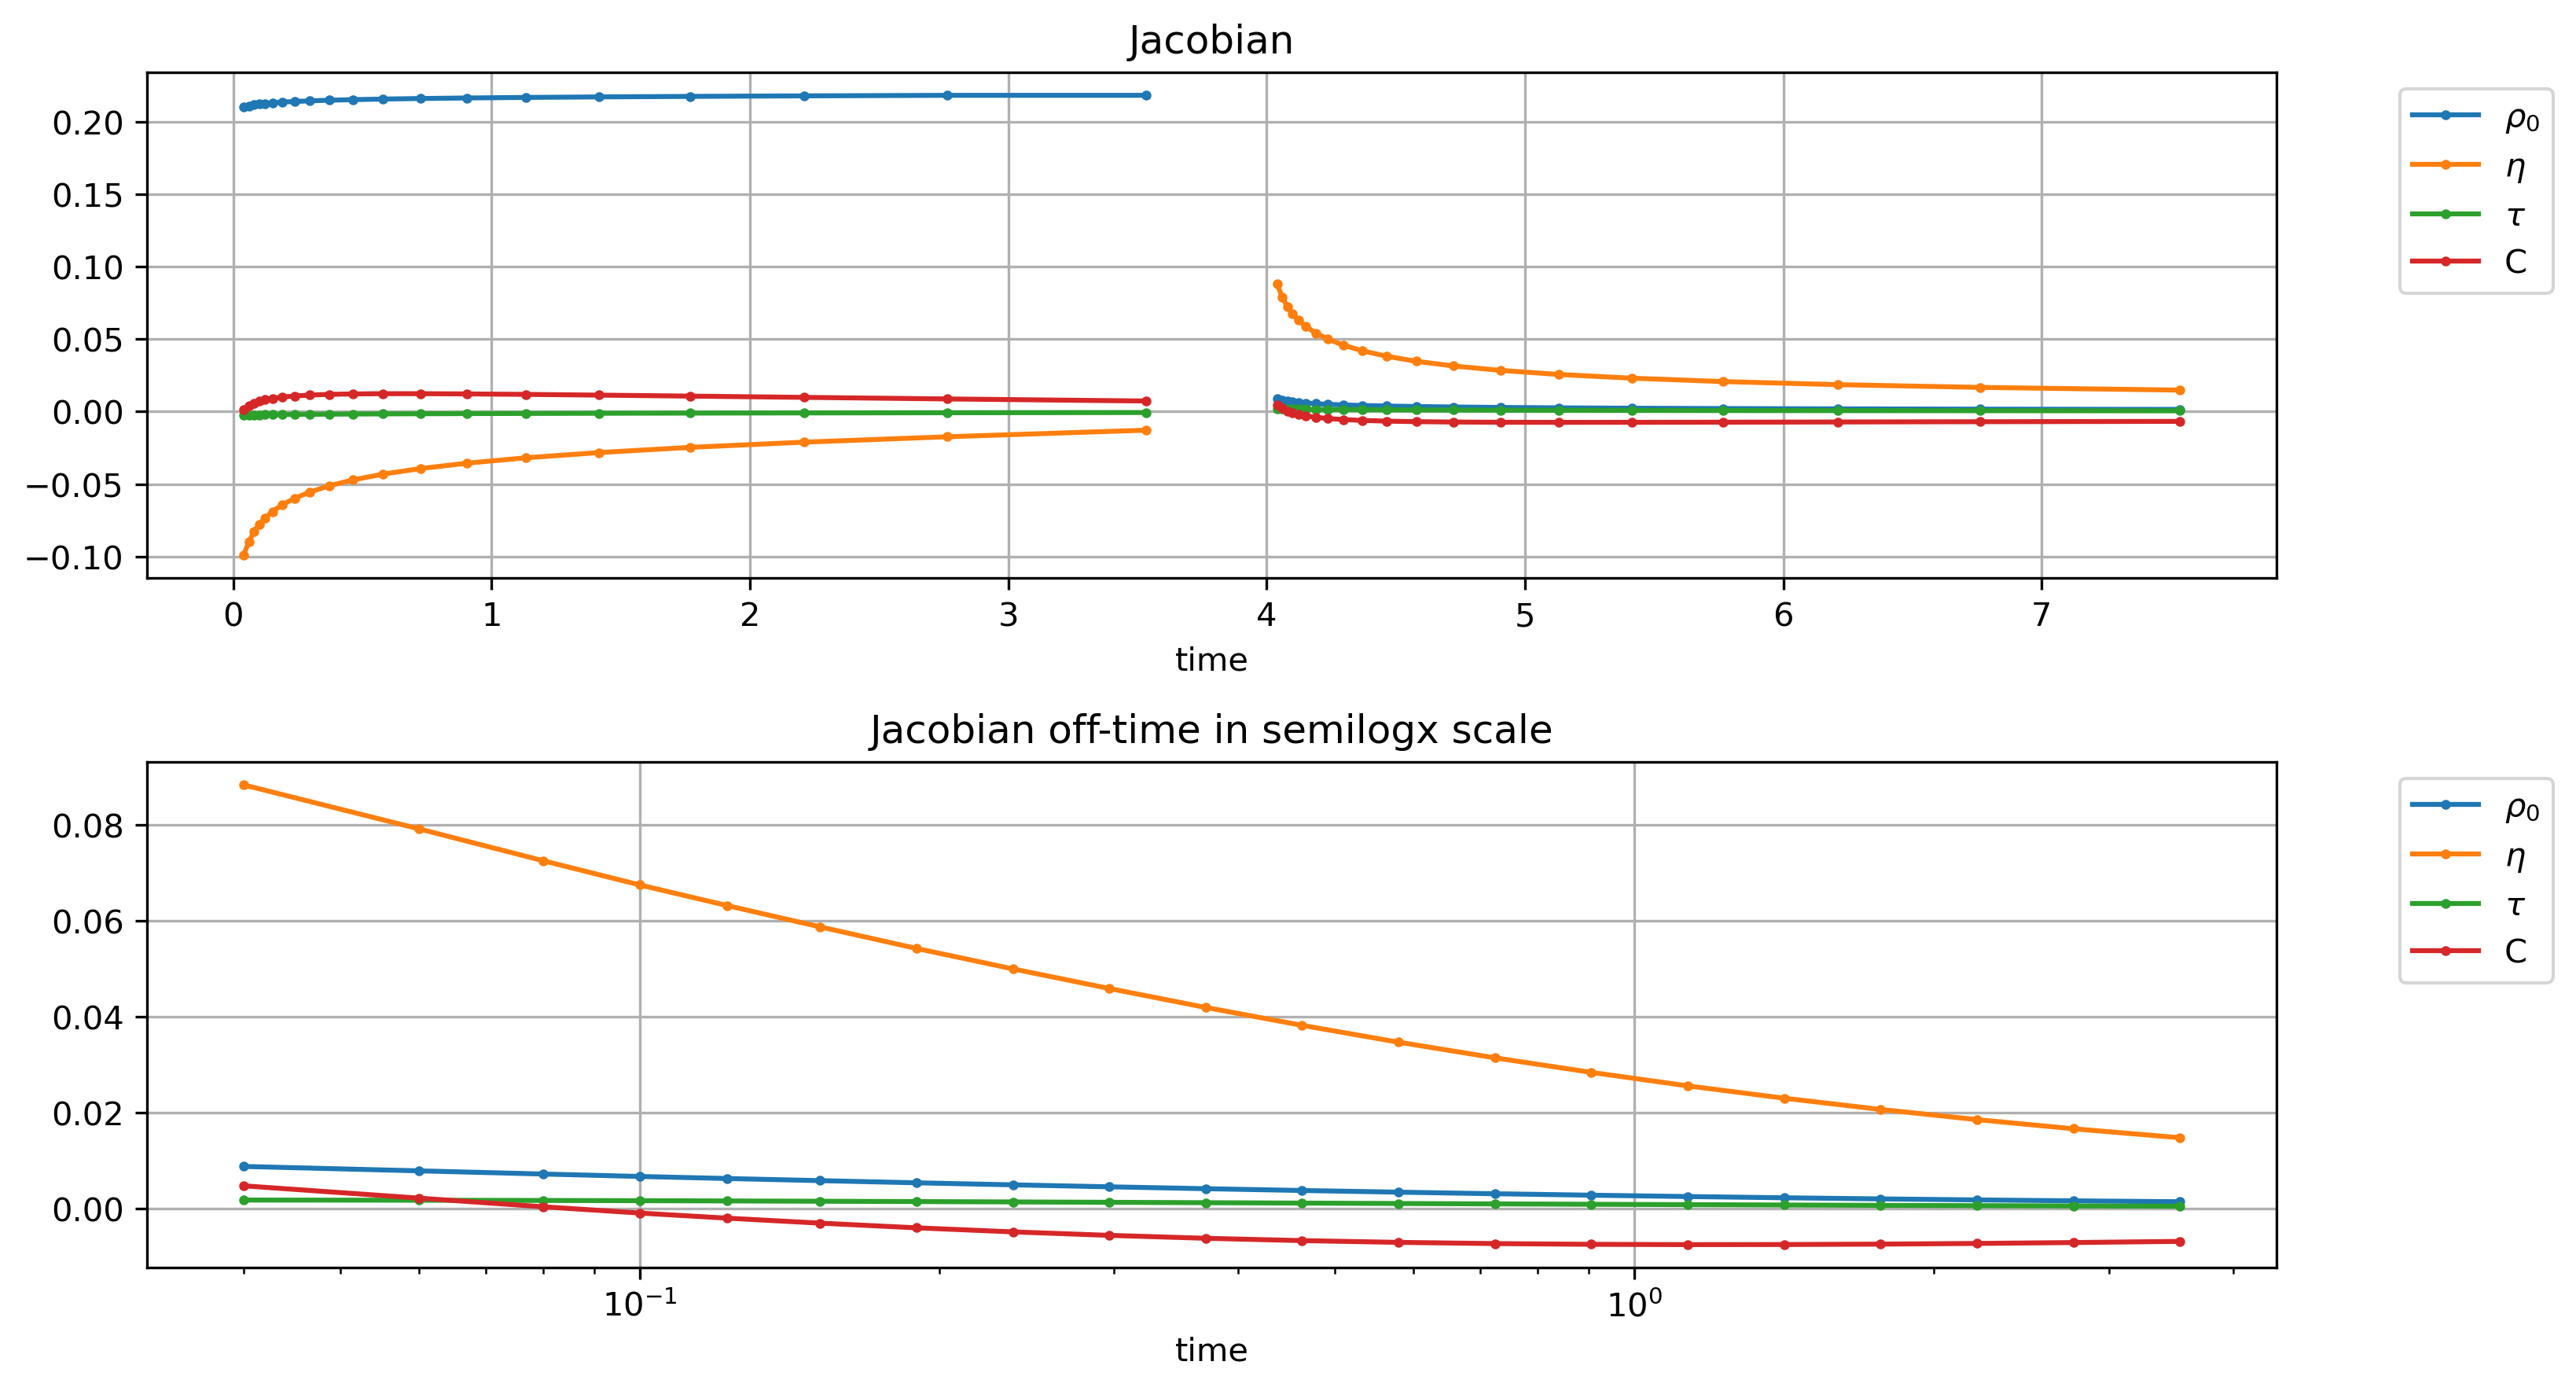

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

ax[0].plot(windows_on, J_on[:,0], 'C0', marker=".",markersize=4.0, label=r"$\rho_0$")
ax[0].plot(windows_off,J_off[:,0], 'C0', marker=".",markersize=4.0)
ax[0].plot(windows_on,J_on[:,1], 'C1', marker=".",markersize=4.0, label=r"$\eta$")
ax[0].plot(windows_off,J_off[:,1], 'C1', marker=".",markersize=4.0,)
ax[0].plot(windows_on,J_on[:,2], 'C2', marker=".",markersize=4.0, label=r"$\tau$")
ax[0].plot(windows_off,J_off[:,2], 'C2', marker=".",markersize=4.0,)
ax[0].plot(windows_on,J_on[:,3], 'C3', marker=".",markersize=4.0, label=r"C")
ax[0].plot(windows_off,J_off[:,3], 'C3', marker=".",markersize=4.0,)

# ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,0], ax=ax[1],
#   marker=".",markersize=4.0,  color='C0', label=r"$\rho_0$")
# ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,1], ax=ax[1],
#   marker=".",markersize=4.0,  color='C1', label=r"$\eta$")
# ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,2], ax=ax[1],
#   marker=".",markersize=4.0,   color='C2', label=r"$\tau$")
# ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,3], ax=ax[1],
#    marker=".",markersize=4.0, color='C3',  label=r"C")
# PL_jac.pl_axes(ax=ax[1])
ax[1].semilogx(windows_off_0, J_off[:,0], 'C0', marker=".",markersize=4.0
, label=r"$\rho_0$")
ax[1].semilogx(windows_off_0, J_off[:,1], 'C1', marker=".",markersize=4.0
, label=r"$\eta$")
ax[1].semilogx(windows_off_0, J_off[:,2], 'C2', marker=".",markersize=4.0
, label=r"$\tau$")
ax[1].semilogx(windows_off_0, J_off[:,3], 'C3', marker=".",markersize=4.0
, label=r"C")



for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("Jacobian")
ax[1].set_title("Jacobian off-time in semilogx scale")

plt.tight_layout()
plt.savefig("43_Pelton_res_tdp_J.jpg", dpi=300)

#  Debye Combination Series

In [81]:
taus_cmb = []
parm_ref = []

# ntau_cmb = [15 ,8 , 11, 6 ]
# taus_strt = [-5,-5,-4, -4 ]
# taus_end = [2,2,1, 1 ]

ntau_cmb = [ 11 , 6 , 7, 4 ]
taus_strt = [-3,-3,-2, -2 ]
taus_end = [2,2,1, 1 ]


for i in range(nref):
    ntau = ntau_cmb[i]
    taus=np.logspace(taus_strt[i], taus_end[i], ntau_cmb[i])
    parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(0.22), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
    ) #, requires_grad=False)

    print(taus) 
    taus_cmb.append(taus)
    parm_ref.append(parm_init)


[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
[ 0.01        0.03162278  0.1         0.31622777  1.          3.16227766
 10.        ]
[ 0.01  0.1   1.   10.  ]


In [82]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    IP_model = Debye_Sum_Ser_t(
        times=times, 
        tstep=tstep,
        taus=taus_cmb[i]
        )
    sim = InducedPolarizationSimulation(
        ip_model=IP_model, 
        times=times, 
        mode="tdip_t"
        )
    sim.set_current_wave(basefreq=basefreq, curr_duty=curr_duty)
    sim.get_windows_matrix_curr(
        smp_freq=smp_freq, 
        nlin=nlin, 
        nlin_strt=nlin_strt
        )
    windows_cen = (sim.windows_strt + sim.windows_end) / 2

    opt = Optimization(sim=sim, dobs=dobs)
    Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.Ws = torch.eye(len(parm_init))
    beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.1980e+10)
  1, beta:1.2e+10, step:9.5e-07, gradient:1.0e+06,  f:5.4e+07
  2, beta:1.2e+10, step:9.5e-07, gradient:2.1e+10,  f:5.4e+07
  3, beta:6.0e+09, step:9.5e-07, gradient:1.0e+10,  f:2.7e+07
  4, beta:6.0e+09, step:9.5e-07, gradient:1.0e+10,  f:2.7e+07
  5, beta:3.0e+09, step:9.5e-07, gradient:5.2e+09,  f:1.3e+07
  6, beta:3.0e+09, step:9.5e-07, gradient:5.2e+09,  f:1.3e+07
  7, beta:1.5e+09, step:9.5e-07, gradient:2.6e+09,  f:6.8e+06
  8, beta:1.5e+09, step:9.5e-07, gradient:2.6e+09,  f:6.8e+06
  9, beta:7.5e+08, step:9.5e-07, gradient:1.3e+09,  f:3.4e+06
 10, beta:7.5e+08, step:9.5e-07, gradient:1.3e+09,  f:3.4e+06
 11, beta:3.7e+08, step:9.5e-07, gradient:6.4e+08,  f:1.7e+06
 12, beta:3.7e+08, step:9.5e-07, gradient:6.4e+08,  f:1.7e+06
 13, beta:1.9e+08, step:9.5e-07, gradient:3.2e+08,  f:8.9e+05
 14, beta:1.9e+08, step:9.5e-07, gradient:3.2e+08,  f:8.9e+05
 15, beta:9.4e+07, step:9.5e-07, gradient:1.6e+08,  f:4.7e+05
 16, beta:9.4e+07, step:9.5e-07, gradient:1.6e+08, 

In [83]:
print( "Parameter:     res0,   chg")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(np_mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg
ref1     & 2.20e-01 & 0.000 
est1     & 2.20e-01 & 0.396
ref2     & 2.20e-01 & 0.000 
est2     & 2.22e-01 & 0.406
ref3     & 2.20e-01 & 0.000 
est3     & 2.11e-01 & 0.378
ref4     & 2.20e-01 & 0.000 
est4     & 2.11e-01 & 0.377
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [84]:
nwindow = len(windows_cen)
ind_on = windows_cen <= duty*(1/basefreq)
ind_off = windows_cen > duty*(1/basefreq)
windows_on = windows_cen[ind_on]
windows_off = windows_cen[ind_off]
windows_off_0 = windows_off-duty*(1/basefreq)

In [85]:
dest_on = []
dest_off = []
dinit_on = []
dinit_off = []
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_on.append(dest[ind_on])
    dest_off.append(dest[ind_off])
    dinit_on.append(dinit[ind_on])
    dinit_off.append(dinit[ind_off])
dobs_on = dobs[ind_on].detach().numpy().flatten()
dobs_off = dobs[ind_off].detach().numpy().flatten()


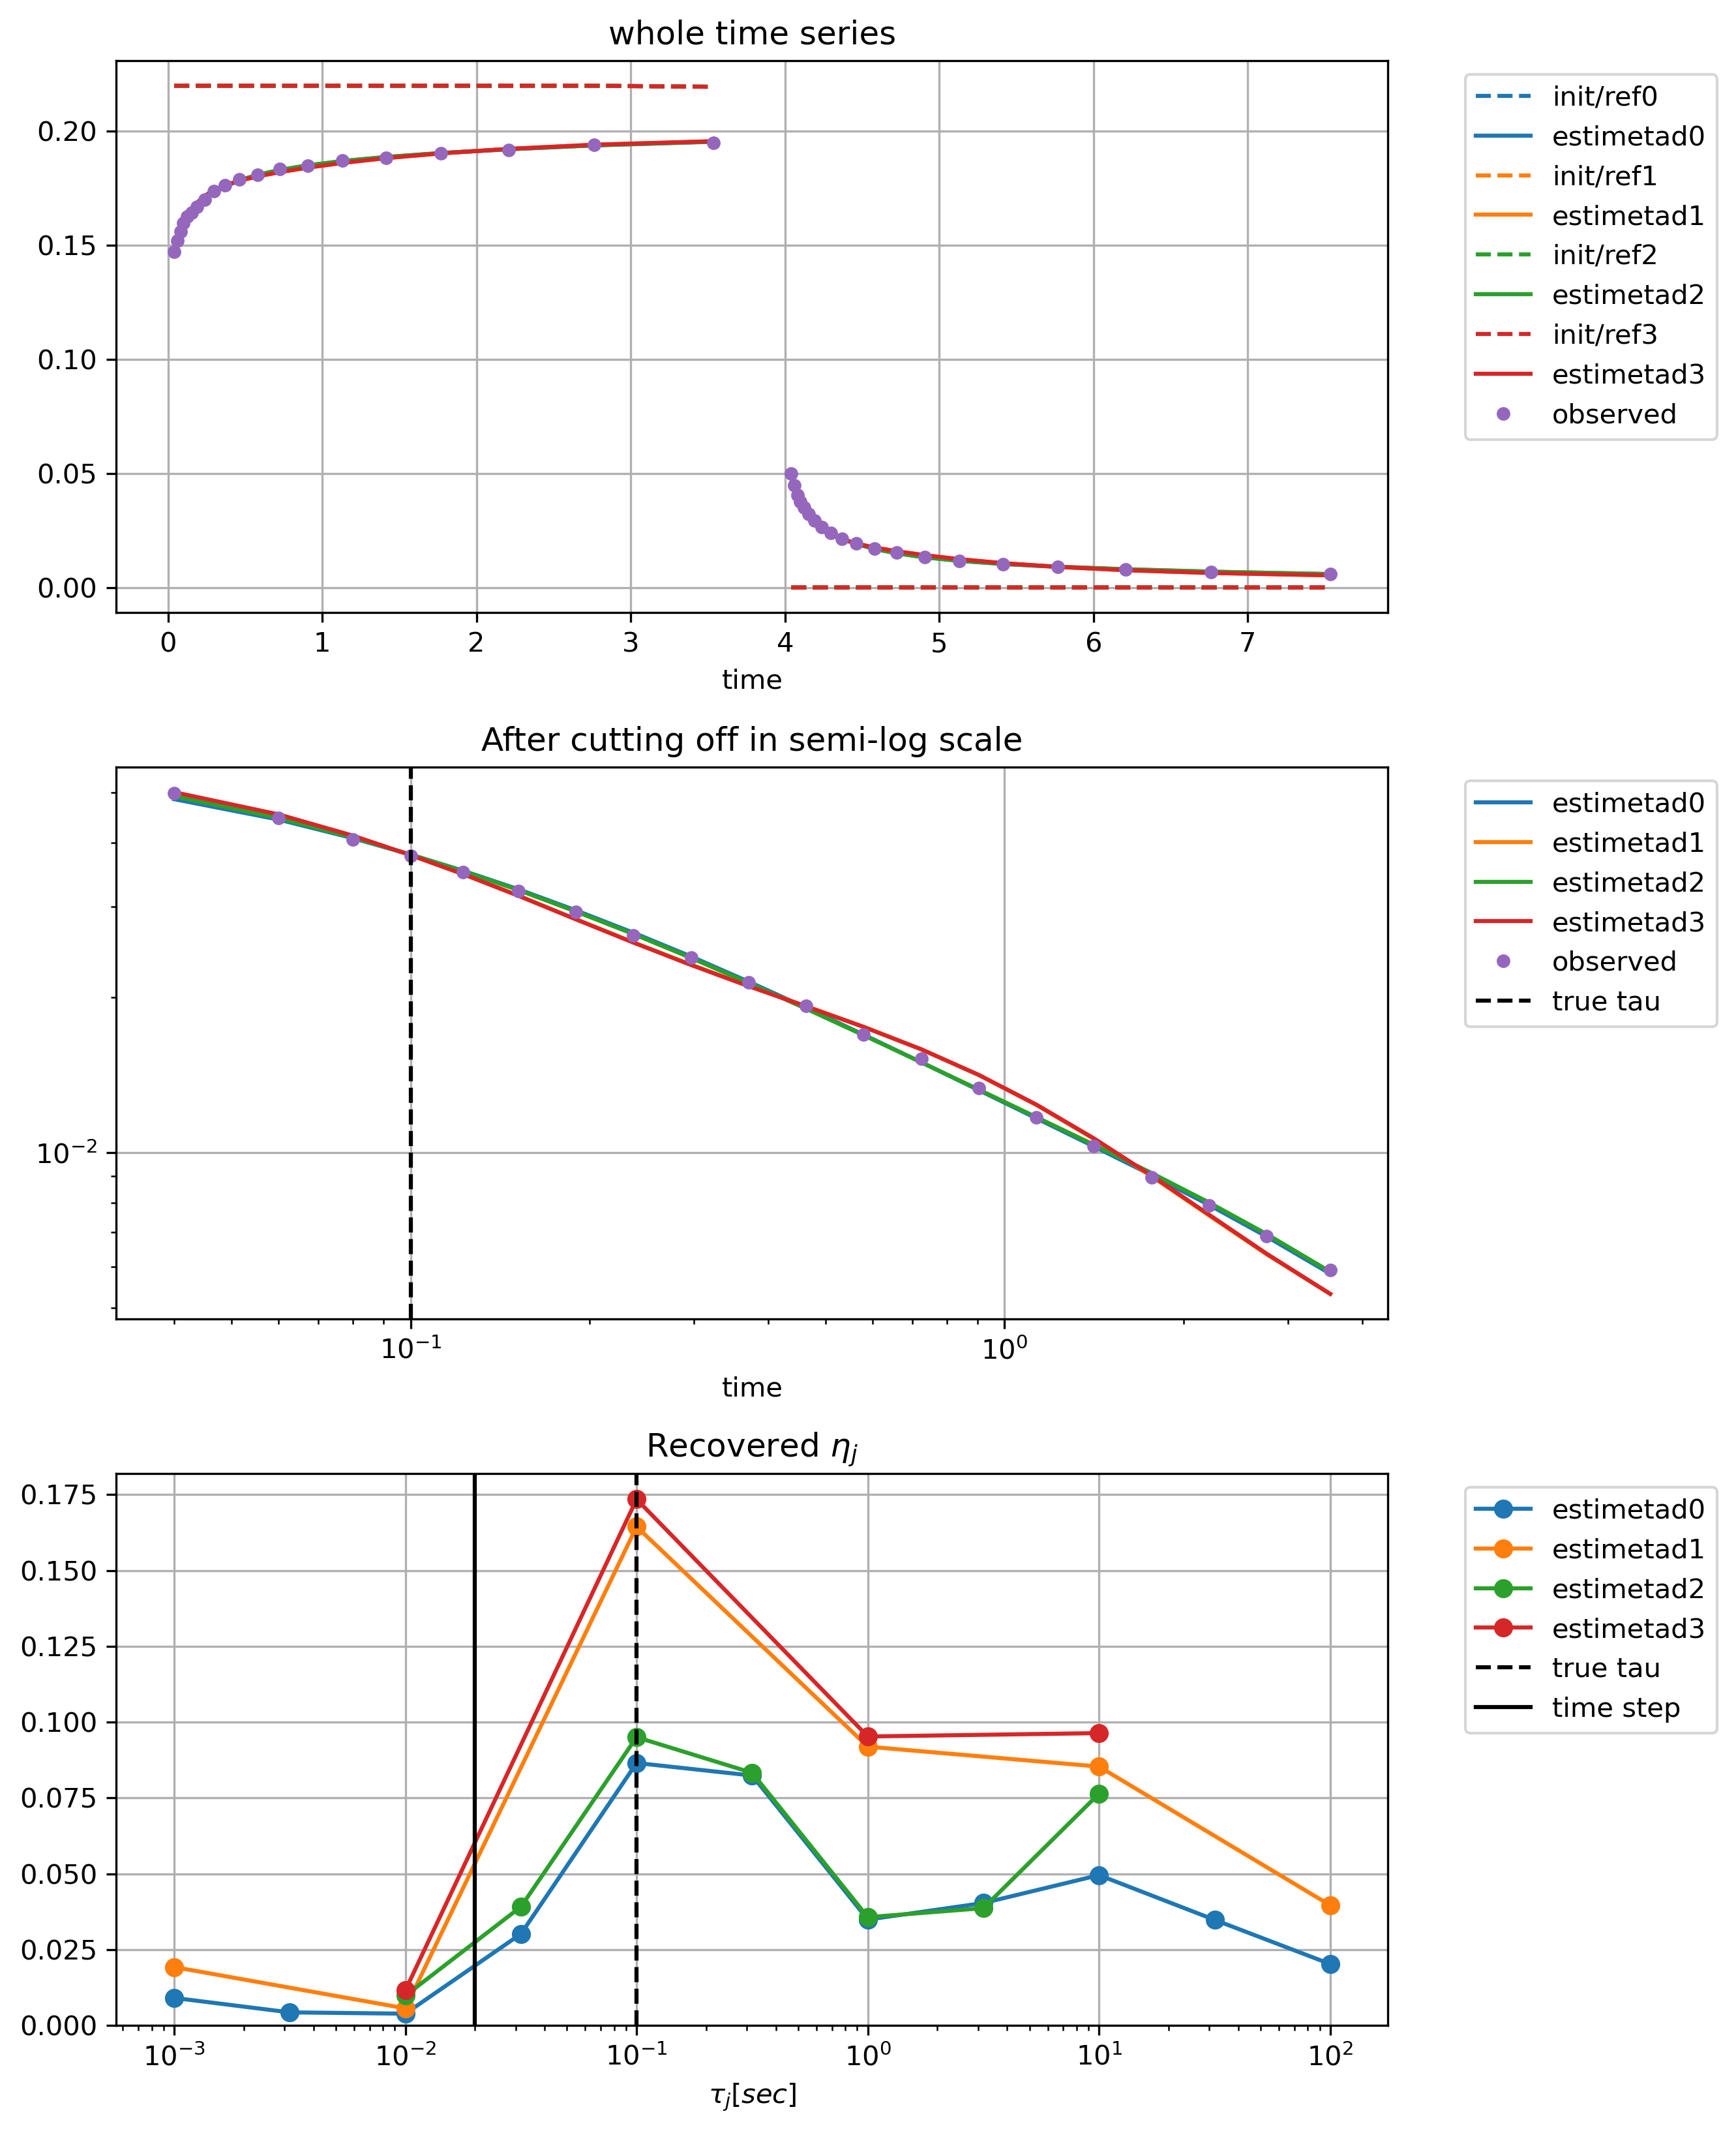

In [127]:
fig, ax = plt.subplots(3, 1, figsize=(9,11),dpi=300)

for i in range(nref):
    np_mvec_est = models_rec[i].detach().numpy()
    taus = taus_cmb[i]
    ax[0].plot(windows_on,dinit_on[i], f'C{i}', linestyle="--",label=f'init/ref{i}')
    ax[0].plot(windows_off,dinit_off[i], f'C{i}', linestyle="--")
    ax[0].plot(windows_on,dest_on[i], f'C{i}', label=f'estimetad{i}')
    ax[0].plot(windows_off,dest_off[i], f'C{i}')
    ax[1].loglog(windows_off_0, dest_off[i], color=f'C{i}', label=f'estimetad{i}')
#     ax[1].loglog(windows_off_0, dinit_off[i],color=f'C{i}', linestyle="--",label=f'init/ref{i}')
    ax[2].semilogx(taus, np_mvec_est[1:], marker="o", color=f'C{i}', label=f'estimetad{i}')
ax[0].plot(windows_on,  dobs_on,  color=f'C{nref}',linestyle="",
            marker="o", markersize=4.0, label='observed')
ax[0].plot(windows_off, dobs_off, color=f'C{nref}', linestyle="",
            marker="o", markersize=4.0)
ax[1].loglog(windows_off_0, dobs_off, color=f'C{nref}', linestyle="",
            marker="o", markersize=4.0, label='observed')
ax[1].axvline(x=tau_true, color='k', linestyle="--", label='true tau')
ax[2].axvline(x=tau_true, color='k', linestyle="--", label='true tau')
ax[2].axvline(x=1/smp_freq, color='k', linestyle="-", label='time step')
ax[2].set_ylim(bottom=0)
for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("After cutting off in semi-log scale")
ax[2].set_title(r"Recovered $\eta_j$")
ax[2].set_xlabel(r"$\tau_j [sec]$")
plt.tight_layout()
plt.savefig("43_Debye_Sum_tdip.jpg", dpi=300)

In [87]:
index =3

IP_model = Debye_Sum_Ser_t(times=times,tstep=tstep,taus=taus_cmb[index])
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="tdip_t", times=times)  
sim.set_current_wave(basefreq=basefreq, curr_duty=curr_duty)
sim.get_windows_matrix_curr(
    smp_freq=smp_freq, 
    nlin=nlin, 
    nlin_strt=nlin_strt
    )
windows_cen = (sim.windows_strt + sim.windows_end) / 2

mpred = models_rec[index]
ntau = ntau_cmb[index]
taus = taus_cmb[index]
J = sim.J(mpred)
J_on = J[ind_on].detach().numpy()
J_off = J[ind_off].detach().numpy()


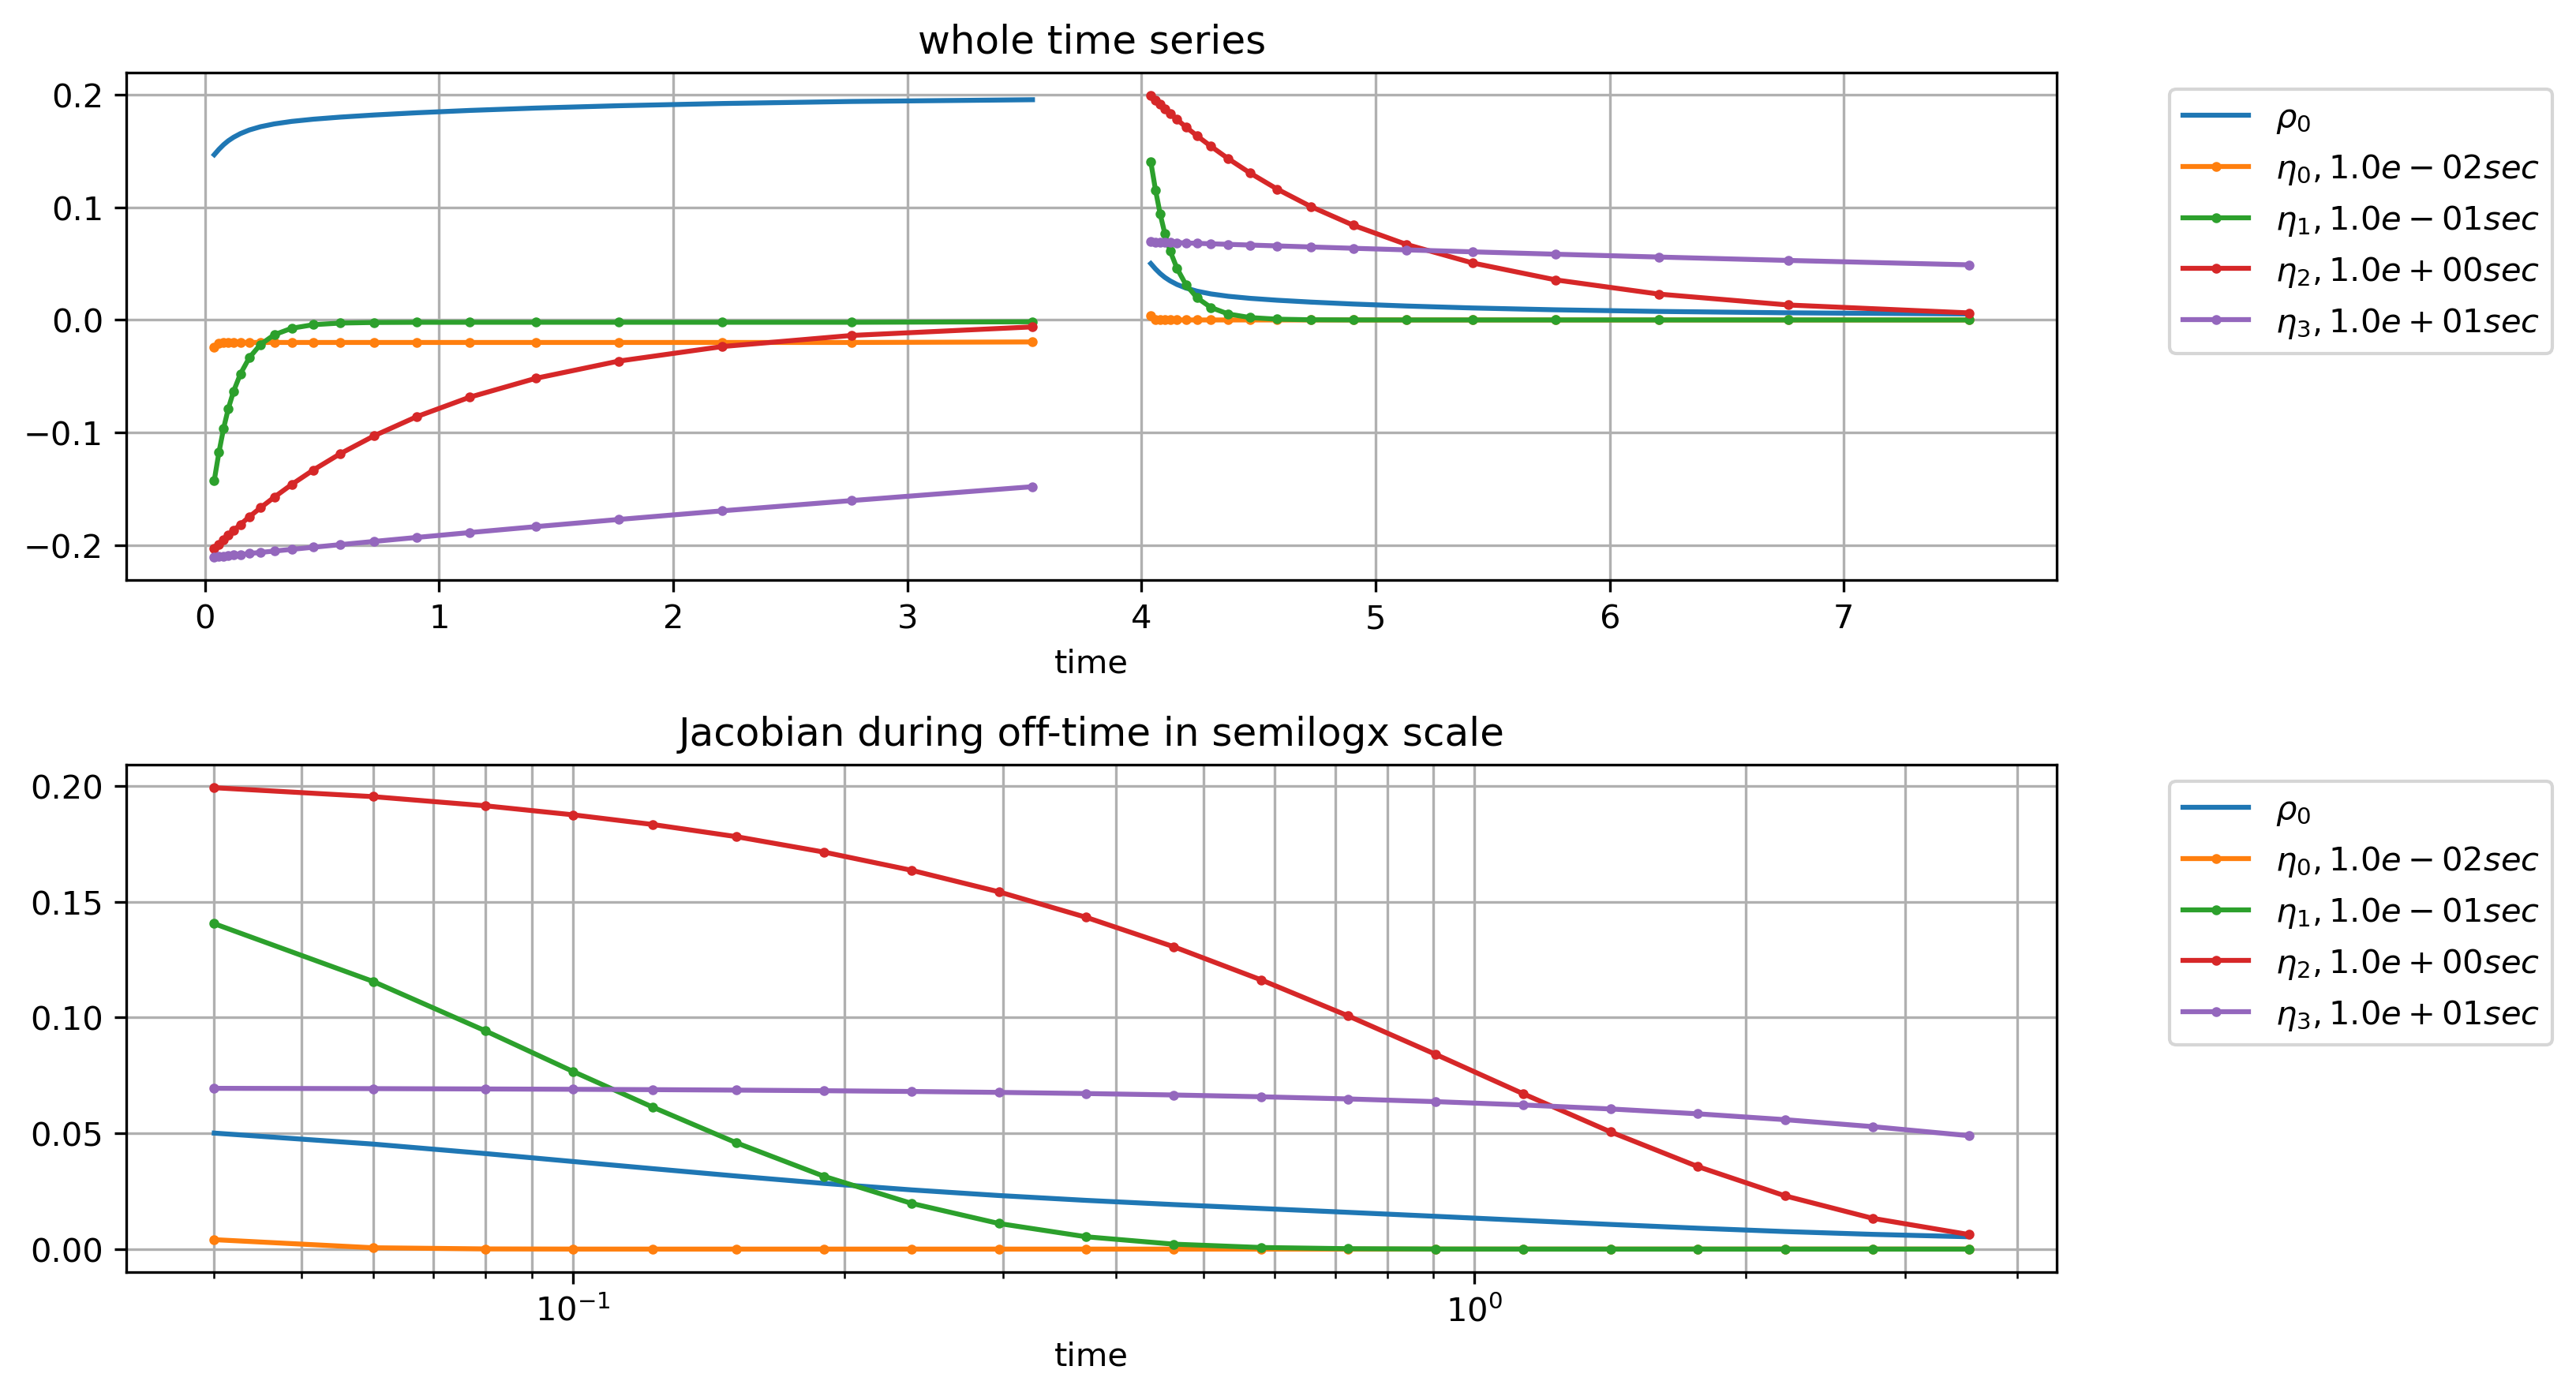

In [88]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

ax[0].plot(windows_on,J_on[:,0], 'C0', label=r"$\rho_0$")
ax[0].plot(windows_off,J_off[:,0], 'C0')
for i in range(ntau):
    ax[0].plot(windows_on,J_on[:,i+1], color=f"C{i+1}", marker=".", markersize=4.0,
      label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[0].plot(windows_off,J_off[:,i+1], color=f"C{i+1}", marker=".", markersize=4.0)

ax[1].semilogx(windows_off_0, J_off[:,0],
             color='C0', label=r"$\rho_0$")
for i in range(ntau):
    ax[1].semilogx(windows_off_0, J_off[:,i+1], marker=".", markersize=4.0,
             color=f"C{i+1}", label=f"$\eta_{i}, {taus[i]:.1e} sec$")

for a in ax:
        a.set_xlabel('time')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("Jacobian during off-time in semilogx scale")
plt.tight_layout()
plt.savefig("43_Debye_Sum_tdip_J.jpg", dpi=300)

# compare singular value of Jacobian

In [89]:
U_debye = []
S_debye=[]
S_debye_norm = []
V_debye=[]
for i in range(nref):
    IP_model = Debye_Sum_Ser_t(times=times,tstep=tstep,taus=taus_cmb[index])
    sim = InducedPolarizationSimulation(
        ip_model=IP_model,
         mode="tdip_t",
         times=times)  
    sim.set_current_wave(basefreq=basefreq, curr_duty=curr_duty)
    sim.get_windows_matrix_curr(
        smp_freq=smp_freq, 
        nlin=nlin, 
        nlin_strt=nlin_strt
        )
    J_np = sim.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_debye.append(U)
    S_debye.append(S)
    s_norm = S/S.max()
    S_debye_norm.append(s_norm)
    V_debye.append(V)


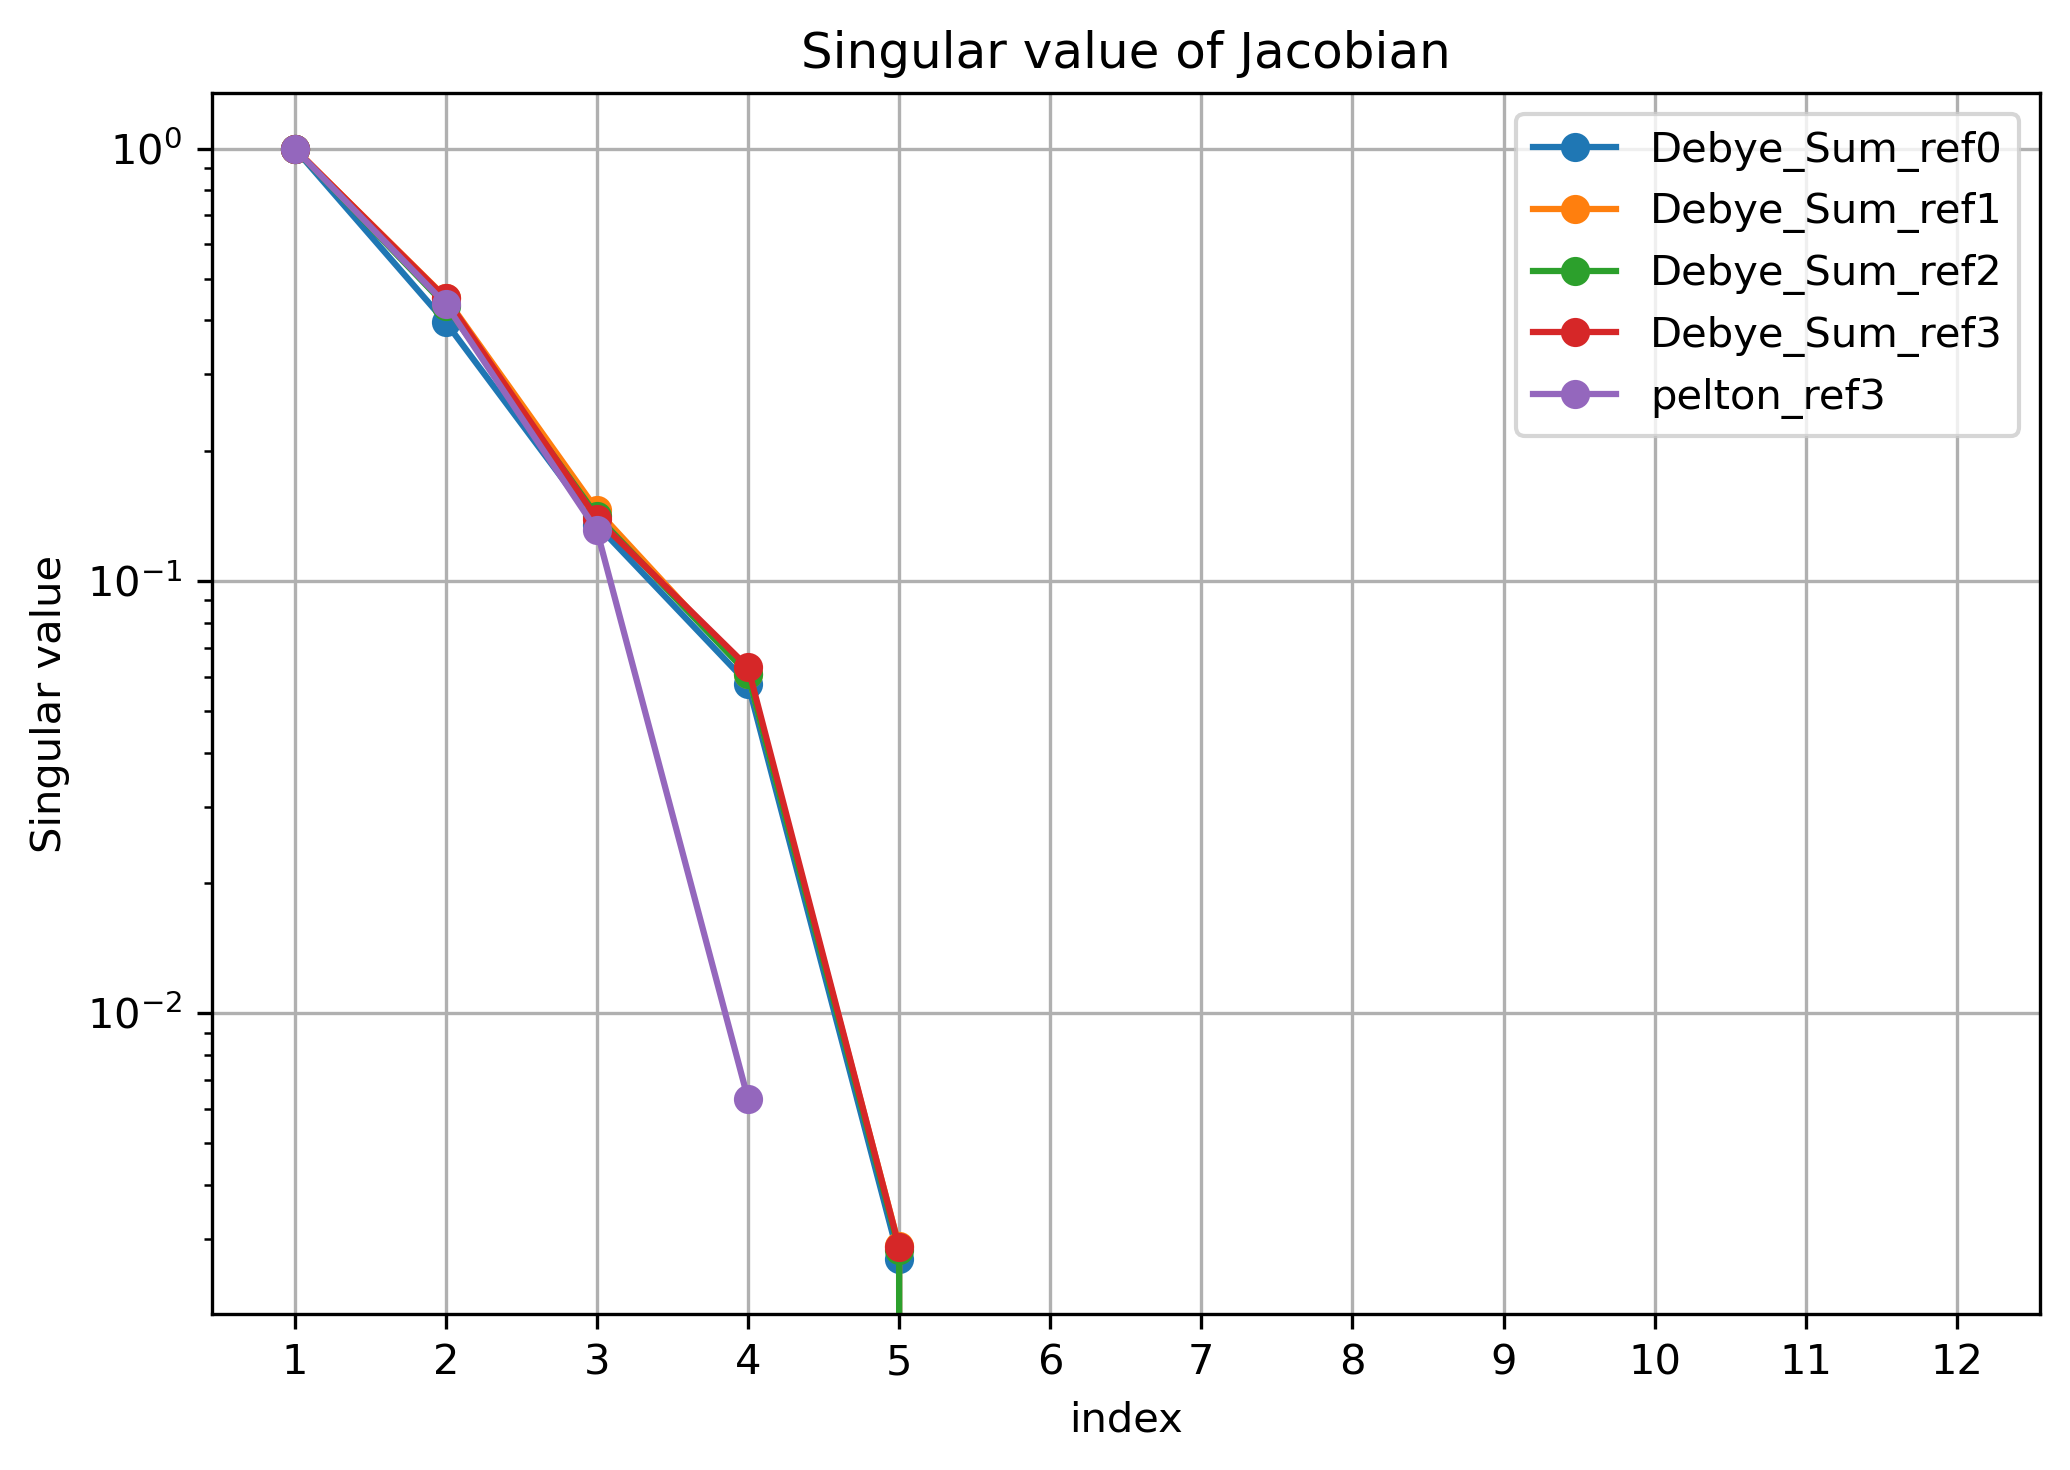

In [93]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
for i in range(nref):
    ax.semilogy(S_debye_norm[i], label=f'Debye_Sum_ref{i}', marker="o")
i=3
ax.semilogy(S_pelton_norm[i], label=f'pelton_ref{i}', marker="o")
ax.set_xticks(range(max(ntau_cmb)+1))
ax.set_xticklabels(np.arange(1,max(ntau_cmb)+2))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("43_tdip_singular.jpg", dpi=300)

# Compare Singular Value with Spectrum IP

In [122]:
index = 2
s_pelton_tdip = S_pelton_norm[index]
index = 3
s_debye_tdip = S_debye_norm[index]


In [123]:
data = np.load("42_SingularValue.npz", allow_pickle=True) 
tmp = data["Pelton"]
index = 1
s_pelton_sip = tmp[index]
tmp= data["Deby_Sum"]
index = 3
s_debye_sip = tmp[index]


In [124]:
ind_max = max(len(s_pelton_tdip), len(s_pelton_sip), len(s_debye_tdip), len(s_debye_sip))

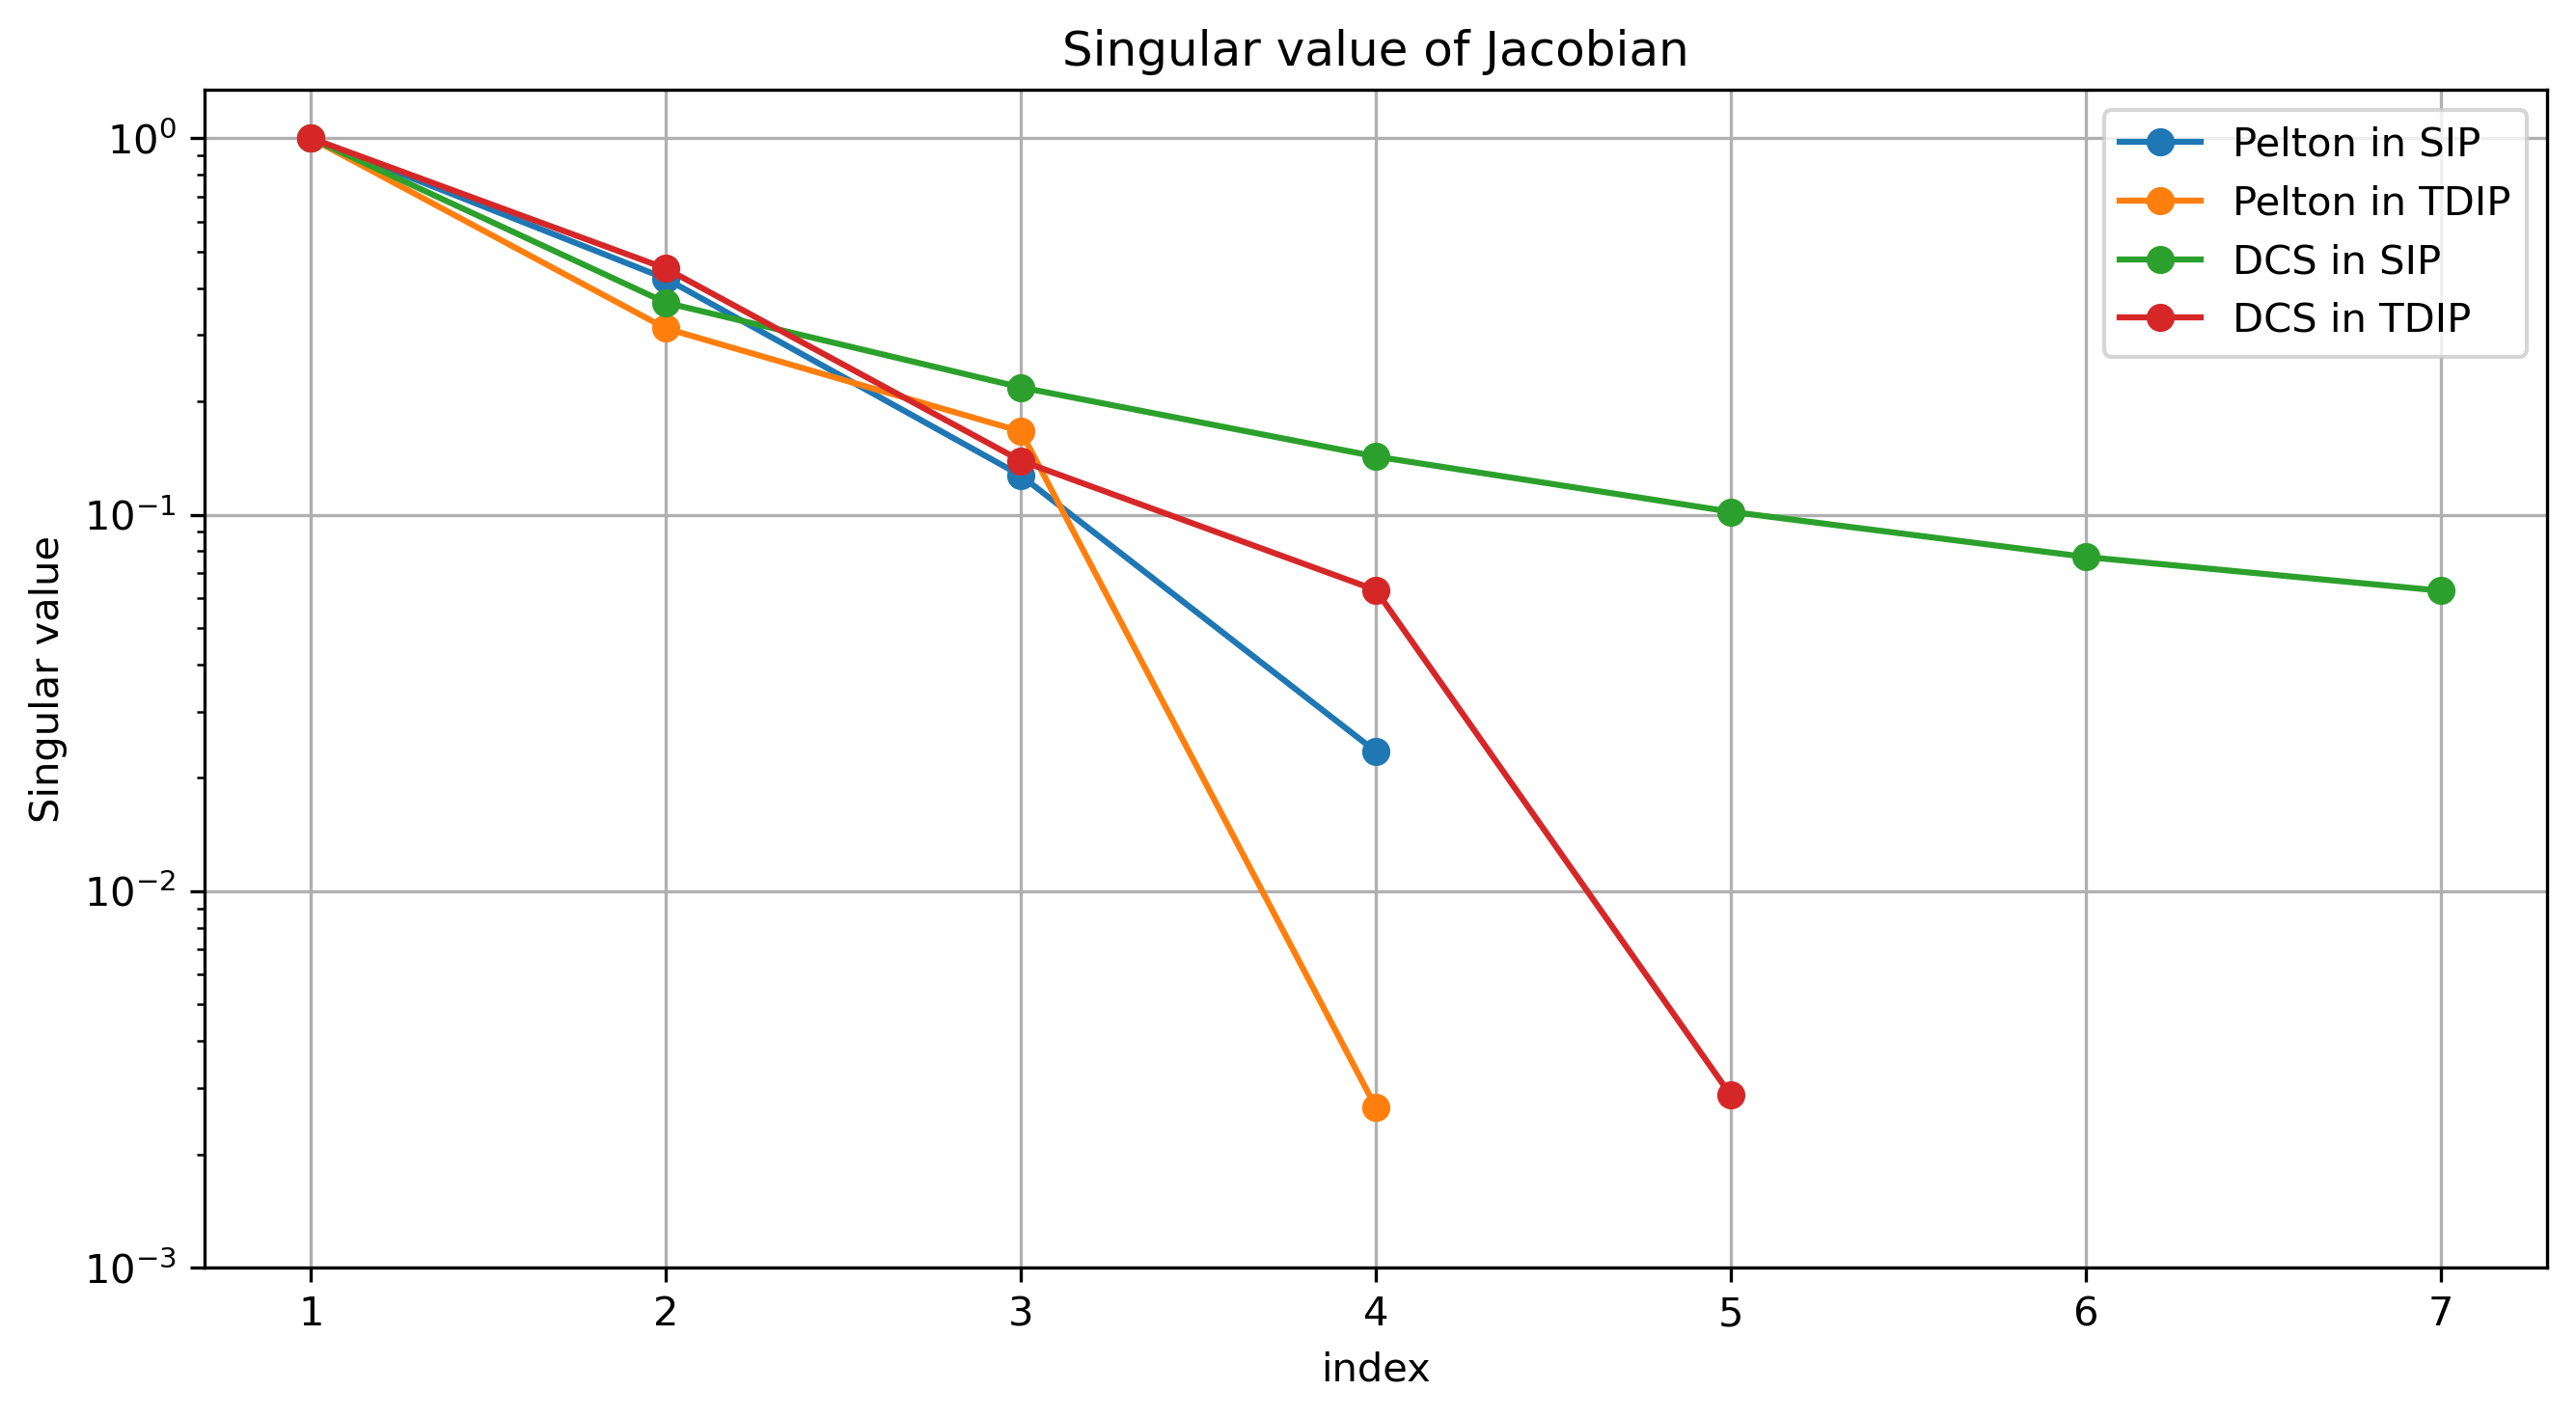

In [125]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
ax.semilogy(s_pelton_sip, label='Pelton in SIP', marker="o")
ax.semilogy(s_pelton_tdip, label='Pelton in TDIP', marker="o")
ax.semilogy(s_debye_sip, label='DCS in SIP', marker="o")
ax.semilogy(s_debye_tdip, label='DCS in TDIP', marker="o")
ax.set_xticks(np.arange(ind_max))
ax.set_xticklabels(np.arange(1,ind_max+1))
ax.set_ylim(bottom=1e-3)
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("43_Singular_Copmparison.jpg", dpi=300)